# Predicting Bike Rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data can be downloaded from [the University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

## Introduction to the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

bike_rentals = pd.read_csv('hour.csv')
print(bike_rentals.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB
None


In [2]:
bike_rentals.sample(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
5015,5016,2011-08-01,3,0,8,21,0,1,1,1,0.70,0.6515,0.70,0.2537,42,178,220
13526,13527,2012-07-22,3,1,7,19,0,0,0,1,0.72,0.6818,0.70,0.1642,180,342,522
536,537,2011-01-24,1,0,1,12,0,1,1,2,0.12,0.1364,0.42,0.1940,11,52,63


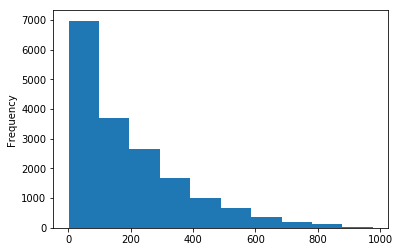

In [3]:
bike_rentals['cnt'].plot.hist()
plt.show()

In [4]:
numeric_bike_rentals = bike_rentals.select_dtypes(include=[np.number])
numeric_bike_rentals.corr()['cnt'].abs().sort_values()

weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
instant       0.278379
hum           0.322911
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Calculating features

In [5]:
def assign_label(val):
    
    if 6 <= val < 12:
        return 1
    elif 12 <= val < 18:
        return 2
    elif 18 <= val <24:
        return 3
    elif 0 <= val < 6:
        return 4
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals['time_label'].value_counts()    

2    4375
3    4368
1    4360
4    4276
Name: time_label, dtype: int64

## Splitting the data into train and test sets

Since the mean squared error metric works on continuous numeirc data, which fits out data quite well, it makes the most sense to use it to evaluate out error.

In [8]:
train = bike_rentals.sample(frac=.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Applying linear regression

Given that many of the columns are highly correlated with cnt, we will apply the linear regression model to train our data first.

Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. 

The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

Note that we need to ignore the casual and registered columns because cnt is derived from them.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

features = train.columns.drop(['cnt', 'casual', 'dteday', 'registered'])
lr = LinearRegression()
lr.fit(train[features], train['cnt'])
predictions_lr = lr.predict(test[features])
mse_lr = mean_squared_error(test['cnt'], predictions_lr)
rmse_lr = np.sqrt(mse)
rmse_lr

131.71195848377167

As we can see that the error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

Now let us try another method to see if there is any improvement.

## Applying decision trees

Decision trees tend to predict outcomes much more reliably than linear regression models, because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [16]:
from sklearn.tree import DecisionTreeRegressor

tr = DecisionTreeRegressor(min_samples_leaf=5)
tr.fit(train[features], train['cnt'])

predictions_tr = tr.predict(test[features])

mse_tr = mean_squared_error(test['cnt'], predictions_tr)
rmse_tr = np.sqrt(mse_tr)

rmse_tr

50.67438635477713

By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.

While due to the way random forests are constructed, they tend to overfit much less than decision trees. We are going to try it out. However, since the random forests are prone to overfitting, it's important to tune parameters like maximum depth and minimum samples per leaf.

## Applying random forests

In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(min_samples_leaf=5)
rf.fit(train[features], train['cnt'])

predictions_rf = rf.predict(test[features])

mse_rf = mean_squared_error(test['cnt'], predictions_rf)
rmse_rf = np.sqrt(mse_rf)
rmse_rf

43.844637994885936

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.

# Next steps

- Calculate additional features, such as:
  - An index combining temperature, humidity, and wind speed
- Predict casual and registered instead of cnt